In [1]:
%load_ext autoreload
%autoreload 1

Adapted from:
* https://www.tensorflow.org/probability/examples/Linear_Mixed_Effects_Model_Variational_Inference

In [2]:
from beanmachine.tutorials.utils.radon import load_data

df = load_data()
df.head()

/root/micromamba/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


,county_index,county,floor,activity,log_activity,Uppm,log_Uppm
0,0,AITKIN,1,2.2,0.832909,0.502054,-0.689048
1,0,AITKIN,0,2.2,0.832909,0.502054,-0.689048
2,0,AITKIN,0,2.9,1.098612,0.502054,-0.689048
3,0,AITKIN,0,1.0,0.095310,0.502054,-0.689048
4,1,ANOKA,0,2.8,1.064711,0.428565,-0.847313


There are two `floor`s with lots of data and many counties with little data.

<AxesSubplot:>

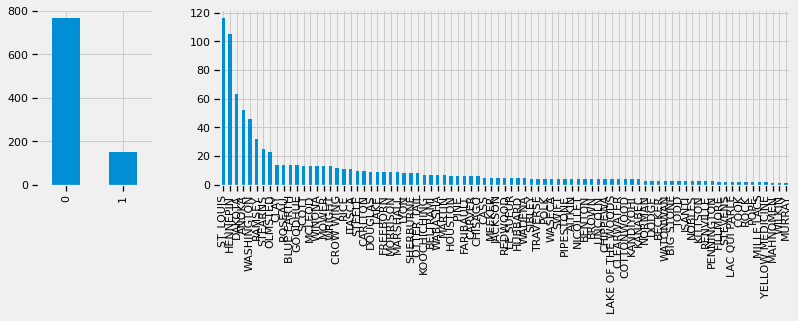

In [3]:
from matplotlib import pyplot as plt; plt.style.use('fivethirtyeight')
import seaborn as sns; sns.set_context('notebook')

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 5]}, figsize=(12, 3))
df['floor'].value_counts().plot(kind='bar', ax=ax[0])
df['county'].value_counts().plot(kind='bar', ax=ax[1])

Since many counties have little data, to avoid overfitting county effects we will model it as a random effect within a GLMM:

$$\log \text{radon}_j \sim c + \text{floor\_effect}_j + \mathcal{N}(\text{county\_effect}_j, \text{county\_scale})$$

Note that the scale here is global across all counties and the random effect is normal; the [hierarchical linear mixed effects models](https://en.wikipedia.org/wiki/Hierarchical_generalized_linear_model) we will look at later will generalize this.

In [62]:
%aimport beanmachine.ppl

In [64]:
df.head()

,county_index,county,floor,activity,log_activity,Uppm,log_Uppm
0,0,AITKIN,1,2.2,0.832909,0.502054,-0.689048
1,0,AITKIN,0,2.2,0.832909,0.502054,-0.689048
2,0,AITKIN,0,2.9,1.098612,0.502054,-0.689048
3,0,AITKIN,0,1.0,0.095310,0.502054,-0.689048
4,1,ANOKA,0,2.8,1.064711,0.428565,-0.847313


In [65]:
import numpy as np

features = df[['county_index', 'floor']].astype(int)
labels = df[['log_activity']].astype(np.float32).values.flatten()

In [66]:
import beanmachine.ppl as bm
import torch
import torch.distributions as dist

floor = torch.tensor(features.floor.values)
county_index = torch.tensor(features.county_index.values)

@bm.random_variable
def county_scale():
    return dist.HalfNormal(scale=1.)

@bm.random_variable
def intercept():
    return dist.Normal(loc=0., scale=1.)

@bm.random_variable
def floor_weight():
    return dist.Normal(loc=0., scale=1.)

@bm.random_variable
def county_prior():
    return dist.Independent(dist.Normal(
        loc=torch.zeros(county_index.unique().numel()),
        scale=county_scale(),
    ), 1)


@bm.random_variable
def linear_response():
    fixed_effect = intercept() + floor_weight() * floor
    random_effect = torch.gather(county_prior(), 0, county_index)
    return dist.Independent(dist.Normal(
        loc=fixed_effect + random_effect,
        scale=1.,
    ), 1)

In [172]:
from torch.distributions import constraints
from torch.distributions.transforms import Transform
import torch.nn.functional as F

class SoftplusTransform(Transform):
    r"""
    Transform via the mapping :math:`y = \log(1 + \exp(x))`

    Source: https://discuss.pytorch.org/t/branching-for-numerical-stability/15763/4
    """
    domain = constraints.real
    codomain = constraints.positive
    bijective = True
    sign = +1

    def __init__(self):
        super().__init__()
        self.threshold = 20

    def _call(self, x):
        return F.softplus(x)

    def _inverse(self, y):
        return torch.where(y>self.threshold, y, y.expm1().log())

    def log_abs_det_jacobian(self, x, y):
        return F.logsigmoid(x)

@bm.param
def phi_loc():
    return torch.rand(3) * 4 - 2

@bm.param
def phi_scale():
    return torch.rand(3) + 0.01

@bm.random_variable
def q_county_scale():
    return dist.TransformedDistribution(dist.Normal(phi_loc()[0], F.softplus(phi_scale()[0])), [SoftplusTransform()])

@bm.random_variable
def q_intercept():
    return dist.Normal(phi_loc()[1], F.softplus(phi_scale()[1]))

@bm.random_variable
def q_floor_weight():
    return dist.Normal(phi_loc()[2], F.softplus(phi_scale()[2]))


# indexing was too hard, so I made another param
# NOTE: can we automate this or make it easier? as a beanstalk fixer?
@bm.param
def phi_county_prior_loc():
    return torch.rand(county_index.unique().numel()) * 4 - 2

@bm.param
def phi_county_prior_scale():
    return torch.rand(county_index.unique().numel()) + 0.01

@bm.random_variable
def q_county_prior():
    return dist.Independent(dist.Normal(
        loc=phi_county_prior_loc(),
        scale=F.softplus(phi_county_prior_scale()),
    ), 1)

In [173]:
from tqdm.auto import tqdm

vi = bm.VariationalInfer(
    queries_to_guides={
        county_prior(): q_county_prior(),
        floor_weight(): q_floor_weight(),
        intercept(): q_intercept(),
        county_scale(): q_county_scale(),
    },
    observations={
        linear_response(): torch.tensor(labels),
    },
    optimizer=lambda params: torch.optim.Adam(params, lr=1e-2),
)

num_steps = 1000
losses = torch.empty(num_steps)
for i in tqdm(range(num_steps)):
    loss, _ = vi.step(num_samples=2)
    losses[i] = loss

world = vi._world
for guide in vi.queries_to_guides.values():
    world.initialize_value(guide)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [174]:
world.get_variable(q_intercept()).distribution

Normal(loc: 0.5969586968421936, scale: 0.21805286407470703)

In [175]:
world.get_variable(q_floor_weight()).distribution

Normal(loc: -0.6024537086486816, scale: 0.27961087226867676)

We have to Monte-Carlo approximate `q_scale_prior` since closed form means are not always available after pushforward (ie `TransformedDistribution.mean` is unimplemented)

In [176]:
scale_prior_sample = world.get_variable(q_county_scale()).distribution.sample((100000,))
print(
    scale_prior_sample.mean(),
    scale_prior_sample.var(),
)

tensor(1.2297) tensor(0.1104)


Text(0, 0.5, 'ELBO')

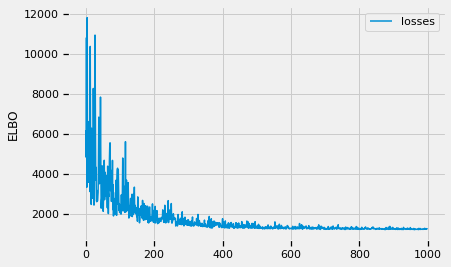

In [177]:
import pandas as pd

ax = pd.DataFrame({
    "losses": losses.detach().numpy()
}).plot(kind='line')
ax.set_ylabel("ELBO")

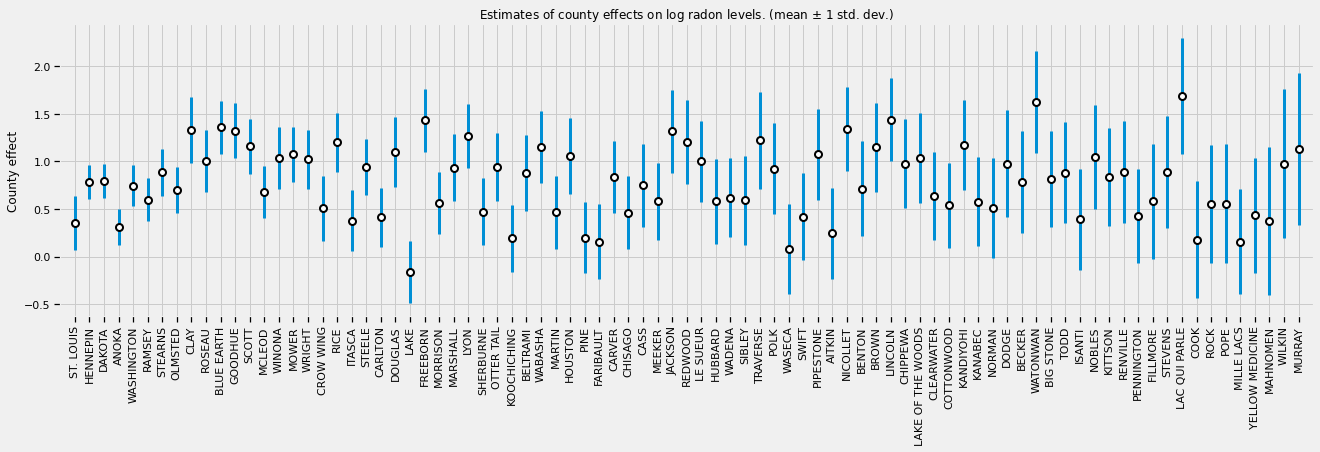

In [178]:
county_counts = (df.groupby(by=['county', 'county_index'], observed=True)
                   .agg('size')
                   .sort_values(ascending=False)
                   .reset_index(name='count'))

means = world.get_variable(q_county_prior()).distribution.base_dist.mean.detach().numpy()
stds = world.get_variable(q_county_prior()).distribution.base_dist.stddev.detach().numpy()

fig, ax = plt.subplots(figsize=(20, 5))

for idx, row in county_counts.iterrows():
  mid = means[row.county_index]
  std = stds[row.county_index]
  ax.vlines(idx, mid - std, mid + std, linewidth=3)
  ax.plot(idx, means[row.county_index], 'ko', mfc='w', mew=2, ms=7)

ax.set(
    xticks=np.arange(len(county_counts)),
    xlim=(-1, len(county_counts)),
    ylabel="County effect",
    title=r"Estimates of county effects on log radon levels. (mean $\pm$ 1 std. dev.)",
)
ax.set_xticklabels(county_counts.county, rotation=90);

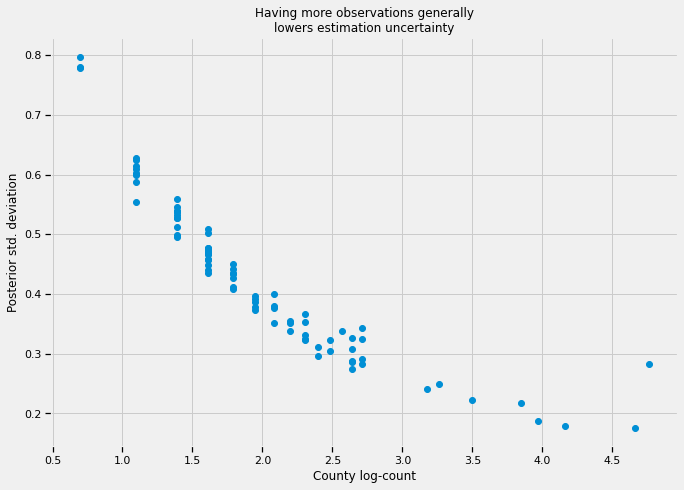

In [179]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(np.log1p(county_counts['count']), stds[county_counts.county_index], 'o')
ax.set(
    ylabel='Posterior std. deviation',
    xlabel='County log-count',
    title='Having more observations generally\nlowers estimation uncertainty'
);